## Thermally driven Convection -pt 2c

Here we move from coarse grids to fine grids - an alternative strategy for accelerating the path to thermal equilibrium.

**NOTE:** I saved all the python setup of the previous notebook in a file so we don't need to type it again. We just do this:


In [7]:
%run "090-RayleighBenardConvection-setup.py"

To make things work, we have three meshes

  - `mesh0` and `Tmesh0`
  - `mesh1` and `Tmesh1`
  - `mesh2` and `Tmesh2`
  
each of which has its own solver (`stokes0` etc) and boundary conditions etc.

The initial condition for `Tmesh0` was already set, but the other meshes are going to be set once we have a low-resoluiton model on the coarser meshes.

We also have `buoyancyFn0` which depends on Rayleigh number as an adjustable function.



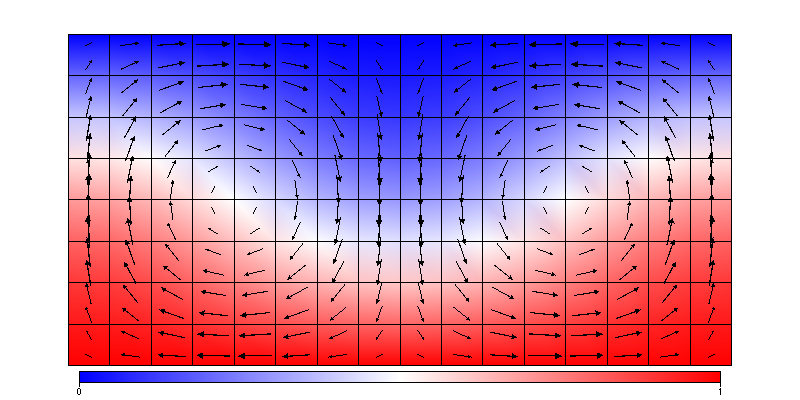

10000.0


In [8]:
# Ready ?

solver0.solve()

# plot figure 

figtemp0 = glucifer.Figure( figsize=(800,400) )
figtemp0.append( glucifer.objects.Surface(mesh0, temperatureField0, colours="blue white red") )
figtemp0.append( glucifer.objects.VectorArrows(mesh0, velocityField0, arrowHead=0.2) )
figtemp0.append( glucifer.objects.Mesh(mesh0))
figtemp0.show()

print Ra

# (YES !)

In [9]:
def Vrms_fn(velocityField):
    int_vdotv_dV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), velocityField.mesh )
    int_1_dV     = uw.utils.Integral( 1.0 , velocityField.mesh )
    Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]

    return Vrms

def Nu_fn(temperatureField):
    
    nuNumerator    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=temperatureField.mesh, integrationType='Surface', 
                              surfaceIndexSet=temperatureField.mesh.specialSets["MaxJ_VertexSet"])

    nuDenominator  = uw.utils.Integral( fn=temperatureField,               
                              mesh=temperatureField.mesh, integrationType='Surface', 
                              surfaceIndexSet=temperatureField.mesh.specialSets["MinJ_VertexSet"])

    Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]
    return Nusselt


In [10]:
glucifer_filename = "Ra-Resolutions"
store = glucifer.Store(filename=glucifer_filename)

frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh0, temperatureField0, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh0, velocityField0, arrowHead=0.2) )
frames.append( glucifer.objects.Mesh(mesh0))

In [11]:
## Take 500 timesteps on the coarsest grid

time = 0.
step = 0
steps_end = 50

Nusselt_t = np.zeros(5000)
Vrms_t = np.zeros(5000)
times_t = np.zeros(5000)

    
step_1 = 0

while step_1 < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver0.solve()
    
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff0.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff0.integrate(dt)  ## <- The explicit timestep computations

    time += dt

    Nusselt_t[step] = Nu_fn(temperatureField0)
    Vrms_t[step] = Vrms_fn(velocityField0)
    times_t[step] = time

    if step%5 == 0:
        store.step=step
        frames.save()
        print("0: Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1
    step_1 += 1
        
        

0: Step = 0 | time = 0.0 | Nusselt = 1.0 | Vrms = 1225.28150106
0: Step = 5 | time = 0.00615255217704 | Nusselt = 1.796228329 | Vrms = 1225.28150106
0: Step = 10 | time = 0.0123051043541 | Nusselt = 2.81309247292 | Vrms = 1225.28150106
0: Step = 15 | time = 0.0184576565311 | Nusselt = 3.58089919 | Vrms = 1225.28150106
0: Step = 20 | time = 0.0246102087082 | Nusselt = 3.92704262954 | Vrms = 1225.28150106
0: Step = 25 | time = 0.0307627608852 | Nusselt = 3.92486397504 | Vrms = 1225.28150106
0: Step = 30 | time = 0.0369153130623 | Nusselt = 3.72864786457 | Vrms = 1225.28150106
0: Step = 35 | time = 0.0430678652393 | Nusselt = 3.48996011955 | Vrms = 1225.28150106
0: Step = 40 | time = 0.0492204174163 | Nusselt = 3.31353780977 | Vrms = 1225.28150106
0: Step = 45 | time = 0.0553729695934 | Nusselt = 3.23856450924 | Vrms = 1225.28150106


KeyboardInterrupt: 

**Plot final temperature and velocity field**


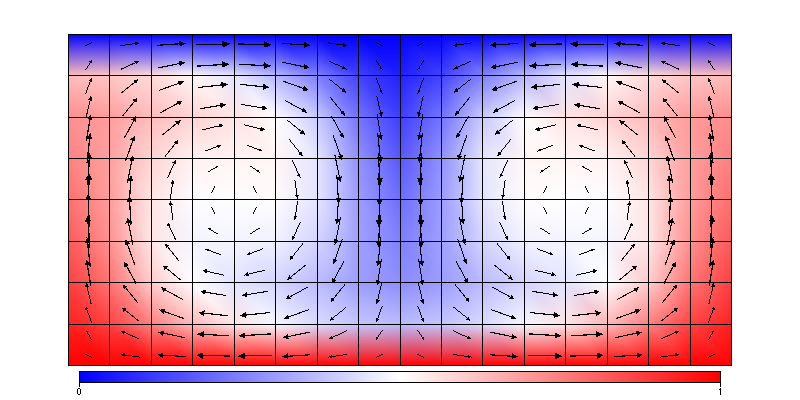

In [12]:
frames.show()

**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer. In the R-B convection example, that means 

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


In [13]:
## Interpolate the temperature from Tmesh0, to Tmesh1

## We probably should re-set boundary conditions but it may not be necessary

temperatureField1.data[:] = temperatureField0.evaluate(mesh1) 

## Resolve

solver1.solve()



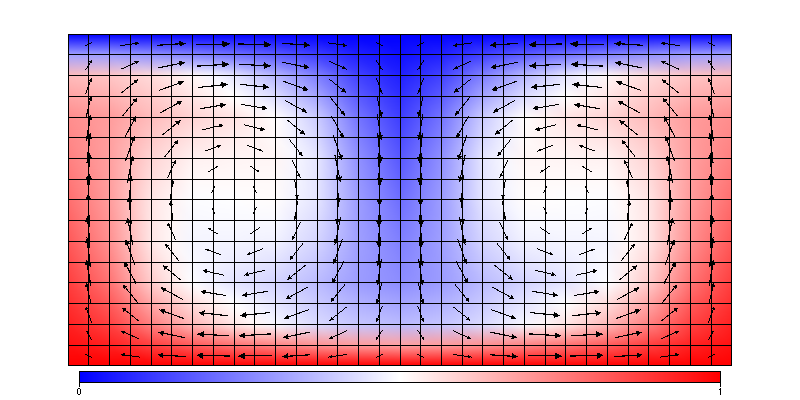

In [14]:
frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh1, temperatureField1, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh1, velocityField1, arrowHead=0.2) )
frames.append( glucifer.objects.Mesh(mesh1))
frames.show()

In [15]:
## Take 500 timesteps on the next grid
    
step_1 = 0

while step_1 < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver1.solve()
    
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff1.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff1.integrate(dt)  ## <- The explicit timestep computations

    time += dt

    Nusselt_t[step] = Nu_fn(temperatureField1)
    Vrms_t[step] = Vrms_fn(velocityField1)
    times_t[step] = time

    if step%5 == 0:
        store.step=step
        frames.save()
        print("0: Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1
    step_1 += 1
        
        

0: Step = 50 | time = 0.0592988342142 | Nusselt = 3.23481818412 | Vrms = 1254.70345605
0: Step = 55 | time = 0.0617402404642 | Nusselt = 3.23481818412 | Vrms = 1254.70345605
0: Step = 60 | time = 0.0641816467142 | Nusselt = 3.23481818412 | Vrms = 1254.70345605


KeyboardInterrupt: 


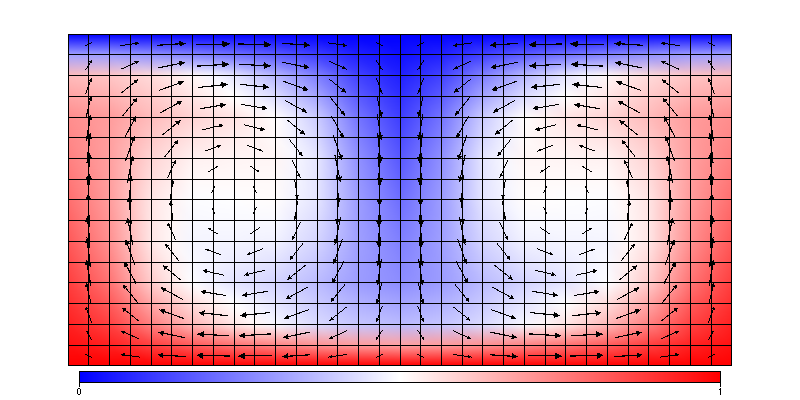

In [16]:
frames.show()

In [17]:
## Interpolate the temperature from Tmesh1, to Tmesh2

## We probably should re-set boundary conditions but it may not be necessary

temperatureField2.data[:] = temperatureField1.evaluate(mesh2) 

## Resolve

solver2.solve()



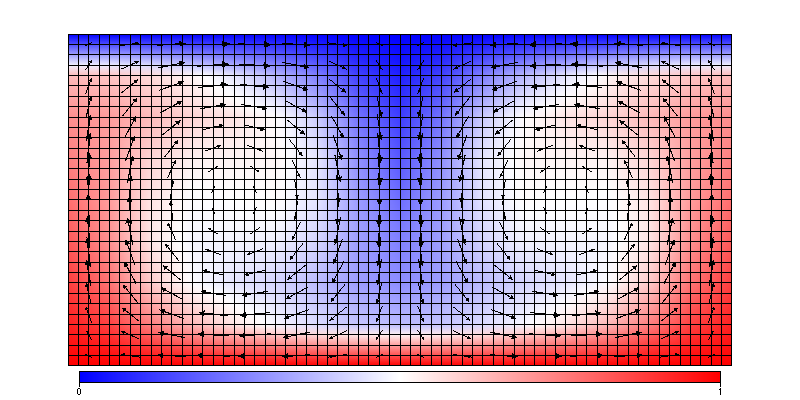

In [18]:
frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh2, temperatureField2, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh2, velocityField2, arrowHead=0.2) )
frames.append( glucifer.objects.Mesh(Tmesh2))
frames.show()

In [19]:
## Take 500 timesteps on the next grid
    
step_1 = 0

while step_1 < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver2.solve()
    
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff2.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff2.integrate(dt)  ## <- The explicit timestep computations

    time += dt

    Nusselt_t[step] = Nu_fn(temperatureField2)
    Vrms_t[step] = Vrms_fn(velocityField2)
    times_t[step] = time

    if step%5 == 0:
        store.step=step
        frames.save()
        print("0: Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1
    step_1 += 1
        
        

NameError: name 'advDiff2' is not defined

In [ ]:
frames.show()

In [ ]:
view = glucifer.lavavu.Viewer(database="{}.gldb".format(glucifer_filename))
# print(view.steps)

view.control.Panel()
view.control.Checkbox(property='axis')
view.control.ObjectList()
view.control.TimeStepper()
view.control.show()

In [ ]:
## Make a plot of Nu / Vrms against time

%matplotlib inline

from matplotlib import pyplot as plt

graph = plt.Figure(figsize=(10,5))
ax = plt.subplot(111)
# ax.set_ylim(3.8,4.4)
ax.plot(times_t[0:1500], Nusselt_t[0:1500])
ax.plot(times_t[0:1500], Vrms_t[0:1500]*0.001)




In [ ]:
print("Nusselt_no at final state - {}".format(Nusselt_t[-1]))
print("Vrms at final state - {}".format(Vrms_t[-1]))